# Deep learning tests

## Load libraries and data

In [36]:
import scipy.io as scio
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.linear_model

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

data = scio.loadmat('tissue14.mat')
calibration = scio.loadmat('cal_14.mat')

In [ ]:
# Look at imported data
for key, value in data.items():
    try:
        print(key, value.shape)
    except:
        print(key, len(value))

In [4]:
target = data['tissue_t14_2']
tissue_data = data['map_t14_2'] 

## Get small img data 

In [5]:
target_simple = target.copy()
for i in range(200):
    for j in range(200):
        if target[i,j] == 2:
            target_simple[i,j]=1
        if target[i,j] == 3:
            target_simple[i,j]=2
        if target[i,j] == 5:
            target_simple[i,j]=3
        if target[i,j] == 6:
            target_simple[i,j]=4
        if target[i,j] == 8:
            target_simple[i,j]=5

In [41]:
sub_images_4 = [] # list: 2500 x 4 x 4 x 1024
target_4 = np.zeros((50,50))

for i in range(50):
    for j in range(50):
        sub_image = tissue_data[i*4:(i+1)*4,j*4:(j+1)*4,:]
        sub_images_4.append(np.array(sub_image))

        array = target_simple[i*4:(i+1)*4,j*4:(j+1)*4].flatten()
        y = np.bincount(array)
        target_4[i,j] = np.argmax(y)

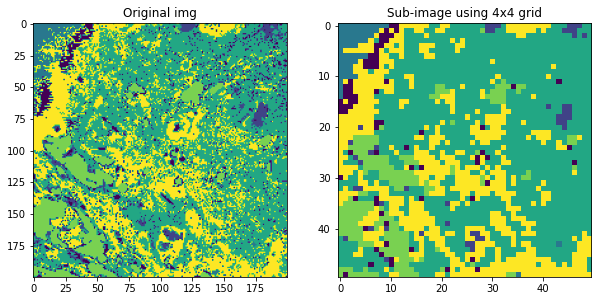

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].imshow(target_simple)
axs[0].title.set_text('Original img')

axs[1].imshow(target_4)
axs[1].title.set_text('Sub-image using 4x4 grid')


## Baseline removal

In [137]:
def remove_baseline(spectrum, window_size=64):
    """
    Use rubber-band method to remove baseline from spectrum
    Input:  - spectrum: np.array
            - window_size (optional): size of rubber-band window
    Output: - smoothed_spectrum: spectrum after baseline removal
    """
    spectrum_len = len(spectrum)  
    num_intervals = int(spectrum_len//window_size)
    
    # Get min value at each interval
    min_values = []
    min_indexes = []
    
    for k in range(int(num_intervals)):
        min_value = np.amax(spectrum[window_size*k : window_size*(k+1)])
        min_index = np.argmax(spectrum[window_size*k : window_size*(k+1)]) + window_size*k
        min_values.append(min_value)
        min_indexes.append(min_index)

    # Fit cubic spline
    cs = CubicSpline(min_indexes,min_values)

    # Remove spline from original spectrum
    smoothed_spectrum = np.zeros(spectrum_len)  
    for i in range(1024):
        smoothed_spectrum[i] = spectrum[i] - cs(i)
            
    return smoothed_spectrum
        

In [141]:
tissue_no_bl = tissue_data.copy()

for i in range(200):
    for j in range(200):
        tissue_no_bl[i,j,:] = remove_baseline(tissue_data[i,j,:])


## Convolutional neural network

In [46]:
y = []
for i in range(50):
    for j in range(50):
        y.append(target_4[i,j])

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(sub_images_4, y, test_size=.1)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

In [48]:
class KerasModel(tf.keras.Model):
    def __init__(self):
        super(KerasModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=100, kernel_size=(3,3), strides=(1,1), padding='same') 
        self.relu1 = tf.keras.layers.Activation('relu')
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')
        self.conv2 = tf.keras.layers.Conv2D(filters=100, kernel_size=(3,3), strides=(1,1), padding='same') 
        self.relu2 = tf.keras.layers.Activation('relu')

        self.flat = tf.keras.layers.Flatten()
        self.drop = tf.keras.layers.Dropout(0.3)

        self.fc1     = tf.keras.layers.Dense(1000)
        self.relu3   = tf.keras.layers.Activation('relu')
        self.fc2     = tf.keras.layers.Dense(6)
        self.softmax = tf.keras.layers.Activation('softmax')
    
    def call(self, x):
        output = self.conv1(x)
        output = self.relu1(output)
        output = self.pool1(output)
        output = self.conv2(output)
        output = self.relu2(output)
    
        output = self.flat(output)
        output = self.drop(output)
        
        output = self.fc1(output)
        output = self.relu3(output)
        output = self.fc2(output)
        output = self.softmax(output)
        return output

In [ ]:
model = KerasModel()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=2000, epochs=3)

In [62]:
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Lambda
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

model = Sequential()

# Resize input image
model.add(Lambda(lambda x: tf.compat.v1.image.resize_images(x, (224, 224)), input_shape=(4,4,1024)))

# 1st Convolutional Layer
model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(10))
model.add(Activation('softmax'))

In [63]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=1000, epochs=500)

C:\Users\MARTINIE\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/500


ValueError: in user code:

    File "C:\Users\MARTINIE\anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\MARTINIE\anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\MARTINIE\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\MARTINIE\anaconda3\lib\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "C:\Users\MARTINIE\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\MARTINIE\anaconda3\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\MARTINIE\anaconda3\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\MARTINIE\anaconda3\lib\site-packages\keras\losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\MARTINIE\anaconda3\lib\site-packages\keras\backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


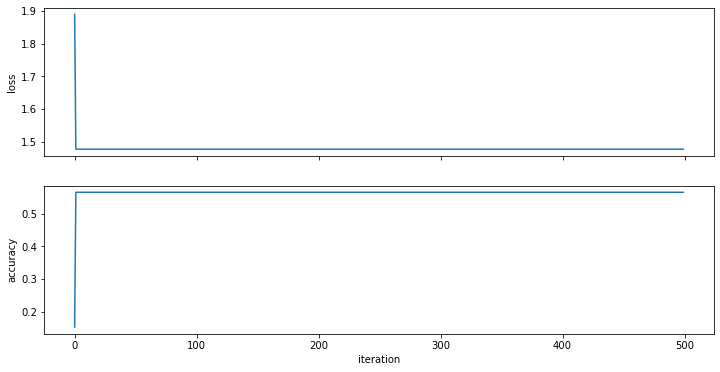

In [13]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(loss_history)
ax1.set_ylabel('loss')
ax2.plot(accuracy_history)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('iteration');

### Let's see how the model does...

In [14]:
model.eval();

In [15]:
tensor_X_test = torch.Tensor(X_test)
tensor_y_test = torch.Tensor(y_test).long()

y_pred_train = model(tensor_X_train) # 32000
y_pred_test = model(tensor_X_test)   #  8000

In [16]:
results = []

for item in y_pred_train:
    array = item.detach().numpy()
    index = np.argmax(array)
    results.append(index)

for item in y_pred_test:
    array = item.detach().numpy()
    index = np.argmax(array)
    results.append(index)
    
approximation = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        index = i*100 + j
        approximation[i,j] = results[index]

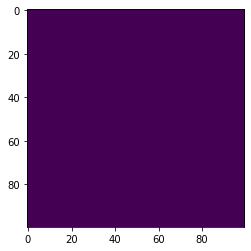

In [17]:
plt.imshow(approximation)